In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
keras = tf.keras

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dty

In [3]:
# 训练和测试数据路径
train_dir = 'train'
validation_dir = 'test'

print('train data dir', train_dir)
print('valid data dir', validation_dir)


train data dir train
valid data dir test


In [4]:

batch_size = 4 # 

epochs = 30 # 训练轮数

# 图像输入尺寸设置
IMG_HEIGHT = 224
IMG_WIDTH = 224

# 类别数目
num_classes = 3

# 训练数据有
train_image_generator = ImageDataGenerator(rescale=1. / 255,
                                           rotation_range = 10, #角度值，0-180.表示图像随机旋转的角度范围
                                           width_shift_range = 0.2, #平移比例，下同
                                           height_shift_range = 0.2,
                                           shear_range = 0.2, #随机错切变换角度
                                           zoom_range = 0.2, #随即缩放比例
                                           horizontal_flip = True, #随机将一半图像水平翻转
                                           fill_mode='nearest') #填充新创建像素的方法

# 验证数据
validation_image_generator = ImageDataGenerator(rescale=1. / 255,
                                                rotation_range = 10, #角度值，0-180.表示图像随机旋转的角度范围
                                                width_shift_range = 0.2, #平移比例，下同
                                                height_shift_range = 0.2,
                                                shear_range = 0.2, #随机错切变换角度
                                                zoom_range = 0.2, #随即缩放比例
                                                horizontal_flip = True, #随机将一半图像水平翻转
                                                fill_mode='nearest') #填充新创建像素的方法 

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          class_mode='categorical')
# 训练和验证数据的数量
total_train_images = train_data_gen.n
total_valid_images = val_data_gen.n

Found 607 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


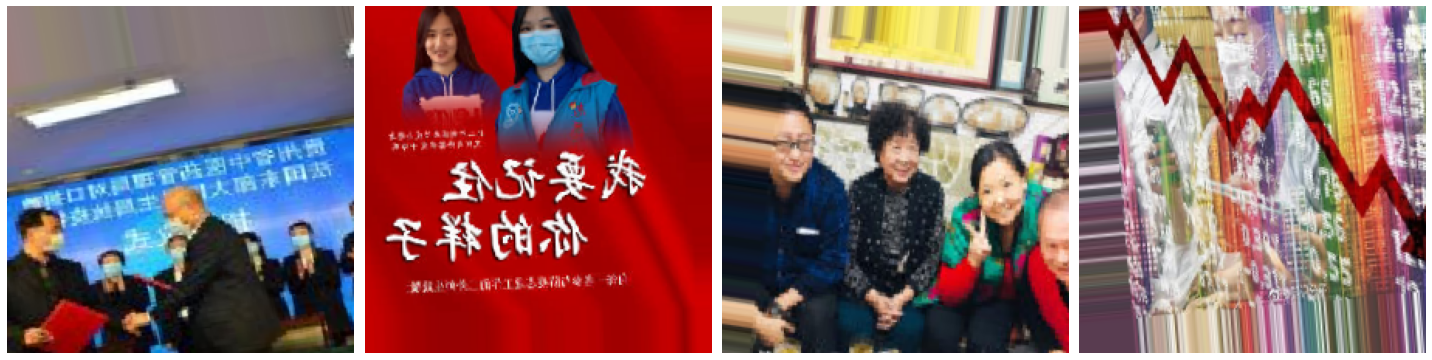

In [5]:
# 数据可视化
# 获取一个batch的数据
sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(sample_training_images[:4])



In [6]:
# 建立模型
# 设置输入图像尺寸
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# 建立MobileNetV2模型，利用ImageNet上训练的MobileNet提取特征
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# 模型参数可学习
base_model.trainable = True

# 打印模型结构
base_model.summary()
plot_model
# 提取特征的尺寸
sample_training_images.shape
#feature_batch = base_model(sample_training_images)
#print(feature_batch.shape)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

NameError: name 'plot_model' is not defined

In [7]:
# 修改模型最后的全连接层，改为自己的数据集的类别数
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # 平均池化层
prediction_layer = keras.layers.Dense(num_classes, activation='softmax') # 全连接层

In [8]:
# 编译模型：模型结构为ImageNet上的特征提取部分+平均池化+全连接层
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


# 学习率设置
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 打印模型结构
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [9]:
# 模型训练 保存最佳模型
filepath = "best_weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max', period=1)
history = model.fit_generator(
    train_data_gen, # 训练数据
    steps_per_epoch=total_train_images // batch_size,
    epochs=epochs,
    validation_data=val_data_gen, # 验证数据
    validation_steps=total_valid_images // batch_size,
    callbacks=[checkpoint]
)

Epoch 1/30
151/151 [==============================] - 71s 467ms/step - loss: 1.6620 - acc: 0.5243 - val_loss: 1.6409 - val_acc: 0.4706
Epoch 2/30
151/151 [==============================] - 54s 359ms/step - loss: 0.9760 - acc: 0.6038 - val_loss: 1.8876 - val_acc: 0.5735
Epoch 3/30
151/151 [==============================] - 55s 362ms/step - loss: 0.9336 - acc: 0.5982 - val_loss: 2.3423 - val_acc: 0.5441
Epoch 4/30
151/151 [==============================] - 55s 366ms/step - loss: 0.8826 - acc: 0.6319 - val_loss: 0.8487 - val_acc: 0.6912
Epoch 5/30
151/151 [==============================] - 56s 374ms/step - loss: 0.8797 - acc: 0.6578 - val_loss: 0.7621 - val_acc: 0.7059
Epoch 6/30
151/151 [==============================] - 56s 373ms/step - loss: 0.8505 - acc: 0.6336 - val_loss: 1.0664 - val_acc: 0.6176
Epoch 7/30
151/151 [==============================] - 57s 380ms/step - loss: 0.8584 - acc: 0.6496 - val_loss: 0.7040 - val_acc: 0.7059
Epoch 8/30
151/151 [==============================] - 5

In [1]:
# 查看训练和验证的准确率

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

Error executing Jupyter command 'nbconvert': [Errno 'jupyter-nbconvert' not found] 2
